# Prediciting market value with XGBoost
CHANEL - 3 datasets (Fashionphile, Amore, Rebag)

In [1]:
# import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns
# this line is needed to display plots in jupyter notebooks
%matplotlib inline
import csv

In [160]:
#reading in merged data (Rebag + Fashionphile + Amore - CHANEL brand)
df = pd.read_csv('CHANEL_clean_mergedALLdata.csv', index_col=0,header=0)
df.head()

,price,production_year,size,color,material,acc_included,condition_ext,other_defects,has_smell,has_chain,has_logo,has_quilts,bag_style,brand
0,2771,2000-2010,large,black,caviar,4,good,0.0,0.0,1.0,1.0,1.0,shoulder_bag,Chanel
1,3050,1980s,small,beige,lambskin,2,good,0.0,0.0,1.0,0.0,1.0,hand_bag,Chanel
3,911,1990s,small,black,lambskin,3,excellent,0.0,0.0,0.0,0.0,1.0,vanity_case,Chanel
5,2771,2000-2010,medium,black,caviar,1,used,0.0,1.0,1.0,0.0,1.0,shoulder_bag,Chanel
6,3236,2000-2010,small,black,lambskin,1,used,0.0,0.0,0.0,0.0,1.0,flap_bag,Chanel


## 1 Building a baseline model with XGBoost

The reasons why I've chosen for Gradient Boosting and XGBoost to predict market value in this dataset:
- GB can handle non-linear relationships and works on medium-sized datasets
- Many of my features are correlated and some of them are not relevant in all cases, GB can handle both correlated and irrelevant features. If in a later phase I want to expand on this idea and add more data of different brands, I'll have several features that will be irrelevant in a part of the dataset
- While GB can be prone to overfitting, this can be prevented by hyperparameter tuning. A random forrest is often more robuust than GB, for this reason I'll also try out a RF later to see if it performs better. However, I've chosen to do GB first since a well-tuned GB model in most cases outperforms a RF
- XGBoost is compatible with multiple libraries that give us an insight into feature importance, such as shap and eli5 - This is very important since I need to know what the effect is of having no input for some features (eg: the user doesn't know in which year the bag was produced.

In [161]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

In [163]:
data = df

cols_to_use = ['acc_included', 'other_defects', 'has_smell','has_logo','has_quilts']
X = data[cols_to_use]
y = data.price

X_train, X_valid, y_train, y_valid = train_test_split(X, y)

my_model = XGBRegressor(random_state=1)

my_model.fit(X_train, y_train)

predictions = my_model.predict(X_valid)
print("Mean Absolute Error: " + str(mean_absolute_error(predictions,y_valid)))

[09:19:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolute Error: 878.7577195177253


## 2 Encoding categorical features

Our baseline model loses valuable data by ignoring all the categorical features, which cannot be used as such in a predictive model.

In order to be able to use the categorical features of our dataset, we'll have to encode these columns. Here I will be using One-Hot encoding for all the categorical features, which generally performs well with categorical variables with a cardinality lower than 15.

In [164]:
from sklearn.preprocessing import OneHotEncoder

df = pd.read_csv('CHANEL_clean_mergedALLdata.csv', index_col=0,header=0)
data = df
y = data['price']
data.drop(['price'], axis=1, inplace=True)
X = data

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2, random_state=0)

numerical_ix = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = X_train.select_dtypes(include=['object']).columns

#print(numerical_ix)
#print(categorical_ix)

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[categorical_ix]))
OH_cols_test = pd.DataFrame(OH_encoder.transform(X_test[categorical_ix]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_test.index = X_test.index

# get the encoded column names
#OH_cols_train.head(5) # encoded column names are currently named numbers 0 to 53
OH_column_names = OH_encoder.get_feature_names(['production_year', 'size', 'color', 'material', 'condition_ext',
       'bag_style', 'brand']) #Get the actual encoded column names back
col_list = list(OH_column_names)
my_dict = {} #create a dictionary with the the encoded column names 
for i in range(len(col_list)):
    my_dict[i] = col_list[i]
# print(my_dict)
OH_cols_train.rename(columns=my_dict,inplace=True)
OH_cols_test.rename(columns=my_dict,inplace=True)

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(categorical_ix, axis=1)
num_X_test = X_test.drop(categorical_ix, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_test = pd.concat([num_X_test, OH_cols_test], axis=1)

#Build a gradient boosting regressor - xgb1
xgb1 = XGBRegressor(random_state=1)

xgb1.fit(OH_X_train, y_train)

predictions = xgb1.predict(OH_X_test)
print("Mean Absolute Error: " + str(mean_absolute_error(predictions,y_test)))

[09:19:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolute Error: 669.6002127378041


In [153]:
OH_cols_train.head()#just checking everything looks okay

,production_year_1980s,production_year_1990s,production_year_2000-2010,production_year_2010-2015,production_year_2015-2020,production_year_No year,size_large,size_medium,size_mini,size_small,...,bag_style_flap_bag,bag_style_hand_bag,bag_style_mini bag,bag_style_shoulder,bag_style_shoulder_bag,bag_style_tote,bag_style_vanity_case,bag_style_waist_bag,bag_style_woc,brand_Chanel
1730,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
728,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
876,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
400,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
893,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [157]:
OH_X_train

,acc_included,other_defects,has_smell,has_chain,has_logo,has_quilts,production_year_1980s,production_year_1990s,production_year_2000-2010,production_year_2010-2015,...,bag_style_flap_bag,bag_style_hand_bag,bag_style_mini bag,bag_style_shoulder,bag_style_shoulder_bag,bag_style_tote,bag_style_vanity_case,bag_style_waist_bag,bag_style_woc,brand_Chanel
1730,3,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
728,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
876,2,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
400,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
893,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,1,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
328,1,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1898,2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
857,3,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [158]:
y_train

1730     370
728     1155
876     2306
400     2435
893     1250
        ... 
940     2306
328     3350
1898    2306
857     4260
982     1290
Name: price, Length: 3140, dtype: int64

In [159]:
# same length OK

## 3 Parameter tuning

#### num_boost_rounds:
corresponds to the number of boosting rounds or trees to build. 

In [154]:
from sklearn.model_selection import GridSearchCV

# Various hyper-parameters to tune
params = {'objective':['reg:linear'],
              'learning_rate': [.3], #so called `eta` value
              'max_depth': [6],
              'min_child_weight': [4],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500],
              'num_boost_round':[5,10,15,20,25,30],}

In [56]:
# Initialize XGB and GridSearch
grid = GridSearchCV(xgb1, params)
grid.fit(OH_X_train, y_train)

# Print the mae
print(mean_absolute_error(y_test, grid.best_estimator_.predict(OH_X_test)))
print(grid.best_params_)

[15:24:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:24:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:24:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:25:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:25:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:25:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:25:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:25:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:25:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

#### max_depth and min_child_weight

Both *max_depth* and *min_child_weight* are parameters that can be used to control the complexity of the trees. 

*max_depth* is the maximum number of nodes from the root to the farthest leaf of a tree. As a tree becomes deeper it can model more complex relationships but also overfit, making the model less relevant

*min_child_weight* is the minimum weight required in order to create a new node in the tree. A smaller min_child_weight will allow for more nodes but will also make the model prone to overfitting.

We will tune both of these parameters together to find a good trade-off between model bias and variance. We will start with values in a pre-defined default range:

In [57]:
params = {'objective':['reg:linear'],
              'learning_rate': [.3], #so called `eta` value
              'max_depth': [5,6,7,8,9,10],
              'min_child_weight': [4,5,6,7,8],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500],
              'num_boost_round':[5,10]}

# Initialize XGB and GridSearch
grid = GridSearchCV(xgb1, params)
grid.fit(OH_X_train, y_train)

# Print the mae
print(mean_absolute_error(y_test, grid.best_estimator_.predict(OH_X_test)))
print(grid.best_params_)

[15:30:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:30:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:30:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:31:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:31:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:31:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:31:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:31:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:31:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[15:37:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:37:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:37:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:37:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:37:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:37:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:37:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:37:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:37:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[15:44:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:45:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[15:52:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:52:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:52:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:52:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:53:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:53:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:53:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:53:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:53:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[16:03:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:03:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:03:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:03:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:03:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:04:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:04:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:04:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:04:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [59]:
params = {'objective':['reg:linear'],
              'learning_rate': [.3],
              'max_depth': [5],#tuned
              'min_child_weight': [6],#tuned
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500],
              'num_boost_round':[5,6,7,8,9]} #doing some more fine-tuning

In [60]:
# Initialize XGB and GridSearch
grid = GridSearchCV(xgb1, params)
grid.fit(OH_X_train, y_train)

# Print the mae
print(mean_absolute_error(y_test, grid.best_estimator_.predict(OH_X_test)))
print(grid.best_params_)

[16:10:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:10:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:10:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:10:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:10:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:10:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:10:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:11:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

**I am for not setting num_boost_rounds on 10 and will change this back at the end!**

#### subsample and colsample_bytree

These parameters control the sampling of the dataset that is done at each boosting round.
Instead of using the whole training set every time, we can build a tree on slightly different data at each step, which makes it less likely to overfit to a single sample or feature.

*subsample* corresponds to the fraction of observations (the rows) to subsample at each step. By default it is set to 1 meaning that we use all rows.

*colsample_bytree* corresponds to the fraction of features (the columns) to use. By default it is set to 1 meaning that we will use all features.

We will be tuning these parameters together:

In [62]:
params = {'objective':['reg:linear'],
              'learning_rate': [.3],
              'max_depth': [5],#tuned
              'min_child_weight': [6],#tuned
              'subsample': [i/10.0 for i in range(3,11)],#TUNING
              'colsample_bytree': [i/10.0 for i in range(3,11)],#TUNING
              'n_estimators': [500],
              'num_boost_round':[10]} #check back at the end

# Initialize XGB and GridSearch
grid = GridSearchCV(xgb1, params)
grid.fit(OH_X_train, y_train)

# Print the mae
print(mean_absolute_error(y_test, grid.best_estimator_.predict(OH_X_test)))
print(grid.best_params_)

[16:18:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:18:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:18:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:18:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:18:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:18:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:18:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:18:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:18:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[16:22:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:22:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:22:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:22:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:22:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:22:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:22:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:22:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:22:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[16:27:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[16:32:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[16:39:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [68]:
params = {'objective':['reg:linear'],
              'learning_rate': [.3],
              'max_depth': [5],#tuned
              'min_child_weight': [6],#tuned
              'subsample': [1.0],#tuned
              'colsample_bytree': [0.3],#tuned
              'n_estimators': [500],
              'num_boost_round':[5,6,7,8]} #check back at the end

In [69]:
# Initialize XGB and GridSearch
grid = GridSearchCV(xgb1, params)
grid.fit(OH_X_train, y_train)

# Print the mae
print(mean_absolute_error(y_test, grid.best_estimator_.predict(OH_X_test)))
print(grid.best_params_)

[18:36:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:36:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:37:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

#### ETA - Learning rate
The ETA parameter controls the learning rate or our model and corresponds to the shrinkage of the weights associated to features after each round. This means that that it defines the amount of "correction" we make at each boosting step.
In order to make our model robust to overfitting, it's good to keep the learning rate low, altough more boosting rounds will be needed with a lower eta, making our model slower


In [70]:
params = {'objective':['reg:linear'],
              'learning_rate': [.3, .2, .1, .05, .01, .005],#tuning
              'max_depth': [5],#tuned
              'min_child_weight': [6],#tuned
              'subsample': [1.0],#tuned
              'colsample_bytree': [0.3],#tuned
              'n_estimators': [500],
              'num_boost_round':[5]} #check back at the end

In [71]:
# Initialize XGB and GridSearch
grid = GridSearchCV(xgb1, params)
grid.fit(OH_X_train, y_train)

# Print the mae
print(mean_absolute_error(y_test, grid.best_estimator_.predict(OH_X_test)))
print(grid.best_params_)

[18:38:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:38:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:38:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:38:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:38:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:38:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:38:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:38:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:38:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [74]:
params = {'objective':['reg:linear'],
              'learning_rate': [.05], #tuned
              'max_depth': [5],#tuned
              'min_child_weight': [6],#tuned
              'subsample': [1.0],#tuned
              'colsample_bytree': [0.3],#tuned
              'n_estimators': [500,600,700,800],
              'num_boost_round':[5]} #check back at the end

# Initialize XGB and GridSearch
grid = GridSearchCV(xgb1, params)
grid.fit(OH_X_train, y_train)

# Print the mae
print(mean_absolute_error(y_test, grid.best_estimator_.predict(OH_X_test)))
print(grid.best_params_)

[18:51:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:51:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:51:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:51:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:51:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:51:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:52:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:52:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:52:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [165]:
params = {'objective':['reg:squarederror'],
              'learning_rate': [.05], #tuned
              'max_depth': [5],#tuned
              'min_child_weight': [6],#tuned
              'subsample': [1.0],#tuned
              'colsample_bytree': [0.3],#tuned
              'n_estimators': [600],
              'num_boost_round':[5,10]} #check back at the end

# Initialize XGB and GridSearch
grid = GridSearchCV(xgb1, params)
grid.fit(OH_X_train, y_train)

# Print the mae
print(mean_absolute_error(y_test, grid.best_estimator_.predict(OH_X_test)))
print(grid.best_params_)

621.2964879392667
{'colsample_bytree': 0.3, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 6, 'n_estimators': 600, 'num_boost_round': 5, 'objective': 'reg:squarederror', 'subsample': 1.0}


In [177]:
# the final parameters for the model
params = {'objective':['reg:squarederror'],
              'learning_rate': .05, #tuned
              'max_depth': 5,#tuned
              'min_child_weight': 6,#tuned
              'subsample': 1.0,#tuned
              'colsample_bytree': 0.3,#tuned
              'n_estimators': 600, #tuned
              'num_boost_round':5} #tuned

In [171]:
#saving the model
best_model = grid.best_estimator_
best_model.save_model("xgb1_tunedCHANEL_alldata.model")

In [176]:
#loading the model and doing predictions
loaded_model = XGBRegressor(random_state=1)
loaded_model.load_model("xgb1_tunedCHANEL_alldata.model")
predictions = loaded_model.predict(OH_X_test)
print("Mean Absolute Error: " + str(mean_absolute_error(predictions,y_test)))

Mean Absolute Error: 621.2964879392667


In [284]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy

In [285]:
evaluate(loaded_model,OH_X_train, y_train)

Model Performance
Average Error: 478.7431 degrees.
Accuracy = 77.45%.


77.44777081166603

NOTE: Repeat HPT with randomized GridSearch (see RF notebook)

## 4 Feature importance 

### 4.1 Permutation Importance

To determine feature importance I'll be using the eli5 library - feature importance through permutation importance is generally one of the most reliable methods!

Feature weights here are calculated by following decision paths in trees of an ensemble. Each leaf has an output score, and expected scores can also be assigned to parent nodes. Contribution of one feature on the decision path is how much expected score changes from parent to child. Weights of all features sum to the output score of the estimator.

In [188]:
#Get the feature importance
import eli5

eli5.explain_weights_xgboost(loaded_model,top = 60, feature_names = OH_X_test.columns.tolist())

Weight,Feature
0.1395,bag_style_flap_bag
0.0680,bag_style_clutch
0.0434,bag_style_tote
0.0402,condition_ext_fair
0.0380,material_caviar
0.0351,material_suede
0.0304,condition_ext_like_new
0.0294,bag_style_shoulder
0.0290,condition_ext_good
0.0281,production_year_2015-2020


Another way to determine feature importance is **permutation importance**. 
Permutation importance is a common, reasonably efficient, and very reliable technique. It directly measures variable importance by observing the effect on model accuracy of randomly shuffling each predictor variable. This technique is broadly-applicable because it doesn't rely on internal model parameters, such as linear regression coefficients (which are really just poor proxies for feature importance).
(see https://explained.ai/rf-importance/ for an interesting read on this info!)

In [207]:
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(loaded_model, random_state=1).fit(OH_X_test, y_test)
names = list(OH_X_test.columns)
eli5.show_weights(perm, feature_names = names)

Weight,Feature
0.2243 ± 0.0374,bag_style_flap_bag
0.0866 ± 0.0105,material_caviar
0.0774 ± 0.0220,bag_style_clutch
0.0487 ± 0.0179,has_quilts
0.0467 ± 0.0160,production_year_2015-2020
0.0411 ± 0.0131,condition_ext_good
0.0382 ± 0.0134,size_mini
0.0350 ± 0.0127,has_chain
0.0348 ± 0.0054,size_small
0.0323 ± 0.0155,acc_included


In [208]:
eli5.show_weights(perm, feature_names = names, top = 60)

Weight,Feature
0.2243 ± 0.0374,bag_style_flap_bag
0.0866 ± 0.0105,material_caviar
0.0774 ± 0.0220,bag_style_clutch
0.0487 ± 0.0179,has_quilts
0.0467 ± 0.0160,production_year_2015-2020
0.0411 ± 0.0131,condition_ext_good
0.0382 ± 0.0134,size_mini
0.0350 ± 0.0127,has_chain
0.0348 ± 0.0054,size_small
0.0323 ± 0.0155,acc_included


In [210]:
eli5.show_weights(perm, feature_names = names, top=5)

### 4.2 XGBoost feature importance 

to compare I will also check XGboost's own feature importance function which in most cases doesn't give very accurate results...

In [185]:
from matplotlib import pyplot
print(loaded_model.feature_importances_)

[0.01876352 0.00673215 0.00713103 0.01924661 0.0096034  0.02243515
 0.00973159 0.01005133 0.01444289 0.01151035 0.02810663 0.01108859
 0.00911053 0.01260114 0.01990673 0.01814285 0.01970598 0.0087104
 0.00921459 0.00798162 0.00626464 0.         0.00547094 0.00525743
 0.01589601 0.00278578 0.00539402 0.0038658  0.00805428 0.00816912
 0.00709012 0.00740996 0.00325982 0.03804656 0.00834019 0.01724456
 0.         0.00887751 0.01645863 0.03512437 0.00969593 0.0085359
 0.01146597 0.04023111 0.02895214 0.03038194 0.01229399 0.02440457
 0.06803467 0.01229114 0.1395165  0.01015798 0.0025051  0.02940762
 0.01500685 0.04340069 0.01095895 0.01279912 0.01273292 0.        ]


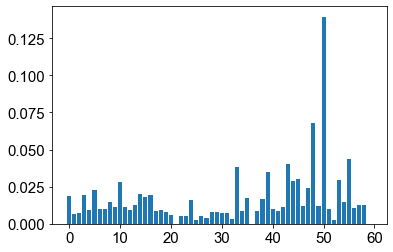

In [186]:
from matplotlib import pyplot
# plot
pyplot.bar(range(len(loaded_model.feature_importances_)), loaded_model.feature_importances_)
pyplot.show()

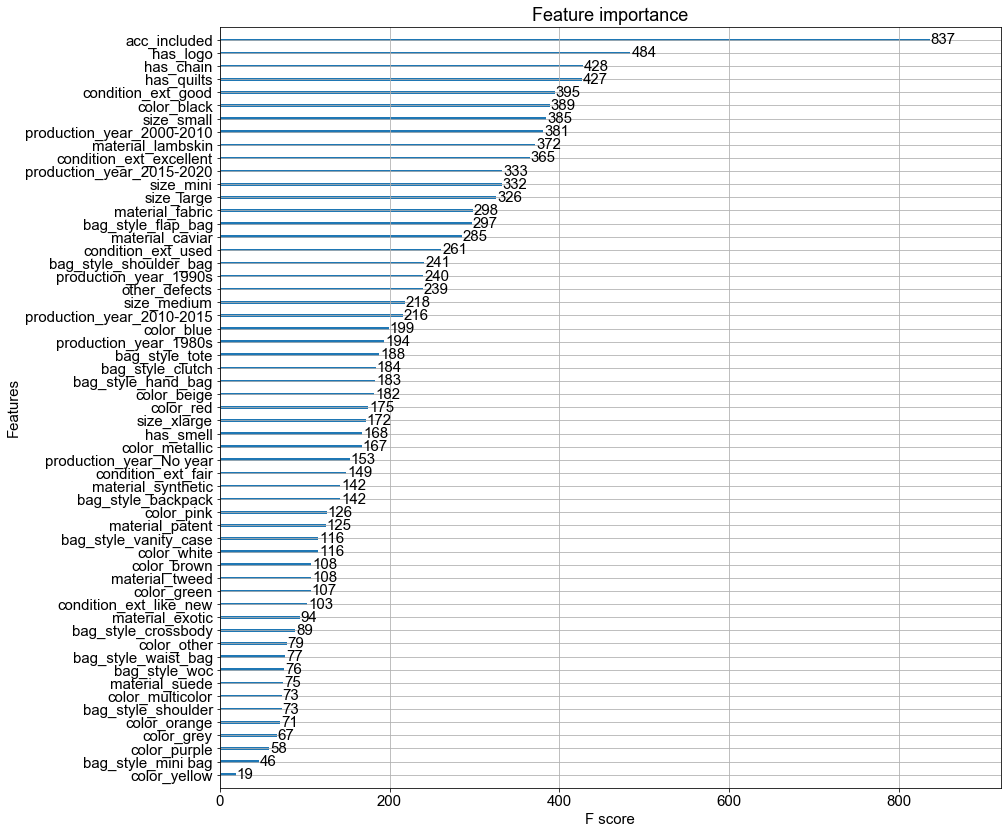

In [198]:
from xgboost import plot_importance

fig, ax = plt.subplots(1,1,figsize=(14,14))

fig=plt.gcf()
plot_importance(loaded_model, ax=ax)
plt.draw()

As mentioned above, Permutation importance is a very reliable technique and the output corresponds with my intuition about the product, much more than XGBoosts feature importance

### 4.3 SHAP Values

SHAP Values (an acronym from SHapley Additive exPlanations) break down a prediction to show the impact of each feature. SHAP values interpret the impact of having a certain value for a given feature in comparison to the prediction we'd make if that feature took some baseline value. SHAP values are a very powerful and robuust tool for confidently interpreting tree models

In summary, Shapley values calculate the importance of a feature by comparing what a model predicts with and without the feature. However, since the order in which a model sees features can affect its predictions, this is done in every possible order, so that the features are fairly compared.

#### SHAP Summary plot

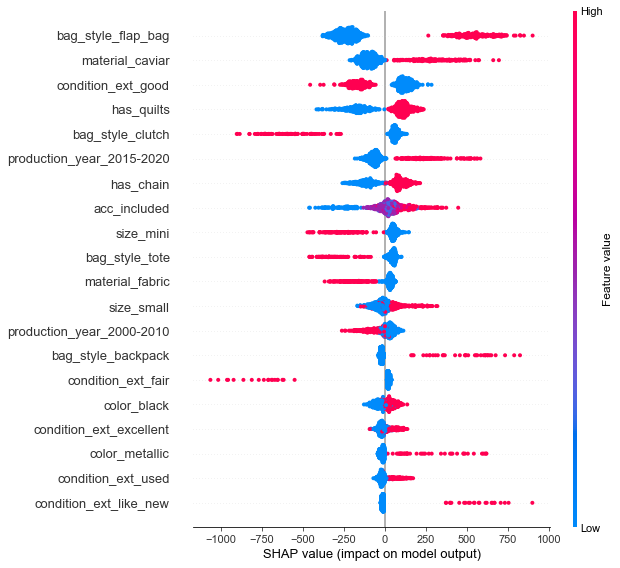

In [221]:
import shap

explainer = shap.TreeExplainer(loaded_model)

shap_values = explainer.shap_values(OH_X_test)

shap.summary_plot(shap_values,OH_X_test)

#### SHAP interaction plot 

See the original SHAP paper for more details, but briefly, SHAP interaction values are a generalization of SHAP values to higher order interactions. Fast exact computation of pairwise interactions are implemented in the latest version of XGBoost with the pred_interactions flag. With this flag XGBoost returns a matrix for every prediction, where the main effects are on the diagonal and the interaction effects are off-diagonal. The main effects are similar to the SHAP values you would get for a linear model, and the interaction effects captures all the higher-order interactions are divide them up among the pairwise interaction terms. Note that the sum of the entire interaction matrix is the difference between the model's current output and expected output, and so the interaction effects on the off-diagonal are split in half (since there are two of each). When plotting interaction effects the SHAP package automatically multiplies the off-diagonal values by two to get the full interaction effect.

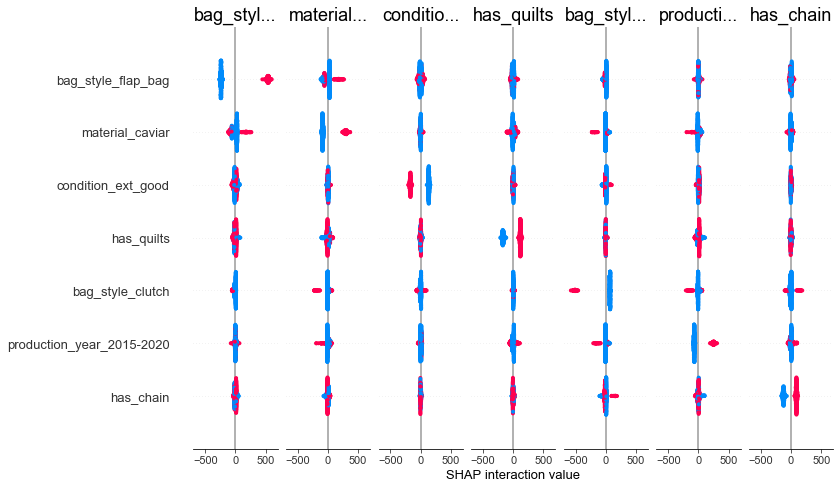

In [224]:
shap_interaction_values = shap.TreeExplainer(loaded_model).shap_interaction_values(OH_X_test.iloc[:2000,:])
shap.summary_plot(shap_interaction_values, OH_X_test.iloc[:2000,:])

#### Individual SHAP value plots

Individual SHAP values are able to explain to what extend a certain prediction was determined by a specific feature having a certain value instead of some baseline value

In [250]:
#OH_X_test.head(10)

X_output = OH_X_test.copy()
X_output.loc[:,'predict'] = np.round(loaded_model.predict(X_output),2)
X_output.tail(20)

,acc_included,other_defects,has_smell,has_chain,has_logo,has_quilts,production_year_1980s,production_year_1990s,production_year_2000-2010,production_year_2010-2015,...,bag_style_hand_bag,bag_style_mini bag,bag_style_shoulder,bag_style_shoulder_bag,bag_style_tote,bag_style_vanity_case,bag_style_waist_bag,bag_style_woc,brand_Chanel,predict
368,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1468.770020
384,2,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3302.979980
4,0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1618.310059
181,1,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2767.290039
219,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1945.280029
1064,3,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2659.020020
505,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1131.729980
199,2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1997.199951
1227,4,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3361.270020
500,3,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4873.890137


Explaining a SHAP plot:
- The output value is the prediction for that observation 
- The base value: The original paper explains that the base value E(y_hat) is “the value that would be predicted if we did not know any features for the current output.” In other words, it is the mean prediction, or mean(yhat). You may wonder why it is 2670. This is because the mean prediction of Y_test is 2670. You can test it out by Y_test.mean() which produces 2670.
- Red/blue: Features that push the prediction higher (to the right) are shown in red, and those pushing the prediction lower are in blue.

Let's generate SHAP plots for some different predictions: 

In [229]:
data_for_prediction = OH_X_test[OH_X_test.index==1]
data_for_prediction

,acc_included,other_defects,has_smell,has_chain,has_logo,has_quilts,production_year_1980s,production_year_1990s,production_year_2000-2010,production_year_2010-2015,...,bag_style_flap_bag,bag_style_hand_bag,bag_style_mini bag,bag_style_shoulder,bag_style_shoulder_bag,bag_style_tote,bag_style_vanity_case,bag_style_waist_bag,bag_style_woc,brand_Chanel
1,2,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [231]:
shap.initjs()
explainer = shap.TreeExplainer(loaded_model)
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

In [232]:
y_test[y_test.index==1]

1    3050
Name: price, dtype: int64

In [236]:
data_for_prediction = OH_X_test[OH_X_test.index==499]
data_for_prediction

,acc_included,other_defects,has_smell,has_chain,has_logo,has_quilts,production_year_1980s,production_year_1990s,production_year_2000-2010,production_year_2010-2015,...,bag_style_flap_bag,bag_style_hand_bag,bag_style_mini bag,bag_style_shoulder,bag_style_shoulder_bag,bag_style_tote,bag_style_vanity_case,bag_style_waist_bag,bag_style_woc,brand_Chanel
499,0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [237]:
shap.initjs()
explainer = shap.TreeExplainer(loaded_model)
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

In [238]:
y_test[y_test.index==499]

499    5350
Name: price, dtype: int64

In [241]:
data_for_prediction = OH_X_test[OH_X_test.index==438]
data_for_prediction

,acc_included,other_defects,has_smell,has_chain,has_logo,has_quilts,production_year_1980s,production_year_1990s,production_year_2000-2010,production_year_2010-2015,...,bag_style_flap_bag,bag_style_hand_bag,bag_style_mini bag,bag_style_shoulder,bag_style_shoulder_bag,bag_style_tote,bag_style_vanity_case,bag_style_waist_bag,bag_style_woc,brand_Chanel
438,3,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [242]:
shap.initjs()
explainer = shap.TreeExplainer(loaded_model)
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

In [243]:
y_test[y_test.index==438]

438    3320
Name: price, dtype: int64

In [244]:
data_for_prediction = OH_X_test[OH_X_test.index==489]
data_for_prediction

,acc_included,other_defects,has_smell,has_chain,has_logo,has_quilts,production_year_1980s,production_year_1990s,production_year_2000-2010,production_year_2010-2015,...,bag_style_flap_bag,bag_style_hand_bag,bag_style_mini bag,bag_style_shoulder,bag_style_shoulder_bag,bag_style_tote,bag_style_vanity_case,bag_style_waist_bag,bag_style_woc,brand_Chanel
489,0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [245]:
shap.initjs()
explainer = shap.TreeExplainer(loaded_model)
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

In [246]:
y_test[y_test.index==489]

489    2695
Name: price, dtype: int64

In [247]:
data_for_prediction = OH_X_test[OH_X_test.index==840]
data_for_prediction

,acc_included,other_defects,has_smell,has_chain,has_logo,has_quilts,production_year_1980s,production_year_1990s,production_year_2000-2010,production_year_2010-2015,...,bag_style_flap_bag,bag_style_hand_bag,bag_style_mini bag,bag_style_shoulder,bag_style_shoulder_bag,bag_style_tote,bag_style_vanity_case,bag_style_waist_bag,bag_style_woc,brand_Chanel
840,2,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [248]:
shap.initjs()
explainer = shap.TreeExplainer(loaded_model)
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

In [249]:
y_test[y_test.index==840]

840    3635
Name: price, dtype: int64

In [251]:
data_for_prediction = OH_X_test[OH_X_test.index==500]
data_for_prediction

,acc_included,other_defects,has_smell,has_chain,has_logo,has_quilts,production_year_1980s,production_year_1990s,production_year_2000-2010,production_year_2010-2015,...,bag_style_flap_bag,bag_style_hand_bag,bag_style_mini bag,bag_style_shoulder,bag_style_shoulder_bag,bag_style_tote,bag_style_vanity_case,bag_style_waist_bag,bag_style_woc,brand_Chanel
500,3,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [252]:
shap.initjs()
explainer = shap.TreeExplainer(loaded_model)
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

In [253]:
y_test[y_test.index==500]

500    4765
Name: price, dtype: int64

In [256]:
data_for_prediction = OH_X_test[OH_X_test.index==4]
data_for_prediction

,acc_included,other_defects,has_smell,has_chain,has_logo,has_quilts,production_year_1980s,production_year_1990s,production_year_2000-2010,production_year_2010-2015,...,bag_style_flap_bag,bag_style_hand_bag,bag_style_mini bag,bag_style_shoulder,bag_style_shoulder_bag,bag_style_tote,bag_style_vanity_case,bag_style_waist_bag,bag_style_woc,brand_Chanel
4,0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [257]:
shap.initjs()
explainer = shap.TreeExplainer(loaded_model)
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

In [258]:
y_test[y_test.index==4]

4    1705
Name: price, dtype: int64

In [259]:
y_test.mean()

2656.1946564885498